GSEAPY Example
-----------------------------------------------
Examples to use ``GSEApy`` inside python console

In [1]:
# %matplotlib inline
# %config InlineBackend.figure_format='retina' # mac
# %load_ext autoreload
# %autoreload 2
import pandas as pd
import gseapy as gp
import matplotlib.pyplot as plt

**Check gseapy version**

In [2]:
gp.__version__

'0.10.6'

## 1.  (Optional) Convert IDs Using Biomart API  

Don't use this if you don't know Biomart
```python
    >>> from gseapy.parser import Biomart 
    >>> bm = Biomart()
    >>> ## view validated marts
    >>> marts = bm.get_marts()
    >>> ## view validated dataset
    >>> datasets = bm.get_datasets(mart='ENSEMBL_MART_ENSEMBL')
    >>> ## view validated attributes
    >>> attrs = bm.get_attributes(dataset='hsapiens_gene_ensembl') 
    >>> ## view validated filters
    >>> filters = bm.get_filters(dataset='hsapiens_gene_ensembl')
    >>> ## query results
    >>> queries = ['ENSG00000125285','ENSG00000182968'] # need to be a python list
    >>> results = bm.query(dataset='hsapiens_gene_ensembl', 
                           attributes=['ensembl_gene_id', 'external_gene_name', 'entrezgene_id', 'go_id'],
                           filters={'ensembl_gene_id': queries})
```

## 2. Enrichr Example

In [3]:
# read in an example gene list
gene_list = pd.read_csv("./tests/data/gene_list.txt",header=None, sep="\t")
gene_list.head()

,0
0,IGKV4-1
1,CD55
2,IGKC
3,PPFIBP1
4,ABHD4


In [4]:
# convert dataframe or series to list
glist = gene_list.squeeze().str.strip().tolist()
print(glist[:10])

['IGKV4-1', 'CD55', 'IGKC', 'PPFIBP1', 'ABHD4', 'PCSK6', 'PGD', 'ARHGDIB', 'ITGB2', 'CARD6']


**See all supported enrichr library names**  

Select database from **{ 'Human', 'Mouse', 'Yeast', 'Fly', 'Fish', 'Worm' }**




Enrichr library could be used for ``gsea``, ``ssgsea``, and ``prerank``, too

In [5]:
names = gp.get_library_name() # default: Human
names[:10]

['ARCHS4_Cell-lines',
 'ARCHS4_IDG_Coexp',
 'ARCHS4_Kinases_Coexp',
 'ARCHS4_TFs_Coexp',
 'ARCHS4_Tissues',
 'Achilles_fitness_decrease',
 'Achilles_fitness_increase',
 'Aging_Perturbations_from_GEO_down',
 'Aging_Perturbations_from_GEO_up',
 'Allen_Brain_Atlas_10x_scRNA_2021']

In [6]:
yeast = gp.get_library_name(organism='Yeast') 
yeast[:10]

['Cellular_Component_AutoRIF',
 'Cellular_Component_AutoRIF_Predicted_zscore',
 'GO_Biological_Process_2018',
 'GO_Biological_Process_AutoRIF',
 'GO_Biological_Process_AutoRIF_Predicted_zscore',
 'GO_Cellular_Component_2018',
 'GO_Cellular_Component_AutoRIF',
 'GO_Cellular_Component_AutoRIF_Predicted_zscore',
 'GO_Molecular_Function_2018',
 'GO_Molecular_Function_AutoRIF']

### 2.1  Assign enrichr with ``pd.Series``,  ``pd.DataFrame``, or ``list`` object

#### 2.1.1 gene_sets support list, str.  
Multi-libraries names supported, separate each name by comma or input a list. 

For example:
```python
    # gene_list
    gene_list="./data/gene_list.txt", 
    gene_list=glist
    # gene_sets
    gene_sets='KEGG_2016'  
    gene_sets='KEGG_2016,KEGG_2013'
    gene_sets=['KEGG_2016','KEGG_2013']
```

In [7]:
# run enrichr
# if you are only intrested in dataframe that enrichr returned, please set no_plot=True

# list, dataframe, series inputs are supported
enr = gp.enrichr(gene_list="./tests/data/gene_list.txt", 
                 gene_sets=['KEGG_2016','KEGG_2013'], 
                 organism='Human', # don't forget to set organism to the one you desired! e.g. Yeast
                 description='test_name',
                 outdir='test/enrichr_kegg', 
                 # no_plot=True,
                 cutoff=0.5 # test dataset, use lower value from range(0,1)
                )

In [8]:
# obj.results stores all results
enr.results.head(5)

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
0,KEGG_2016,Osteoclast differentiation Homo sapiens hsa04380,28/132,3.104504e-13,7.885440e-11,0,0,6.659625,191.802220,LILRA6;ITGB3;LILRA2;LILRA5;PPP3R1;FCGR3B;SIRPA...
1,KEGG_2016,Tuberculosis Homo sapiens hsa05152,31/178,4.288559e-12,5.446470e-10,0,0,5.224941,136.763196,RAB5B;ITGB2;PPP3R1;HLA-DMA;FCGR3B;HLA-DMB;CASP...
2,KEGG_2016,Phagosome Homo sapiens hsa04145,28/154,1.614009e-11,1.366528e-09,0,0,5.490501,136.437381,ATP6V1A;RAB5B;ITGB5;ITGB3;ITGB2;HLA-DMA;FCGR3B...
3,KEGG_2016,Rheumatoid arthritis Homo sapiens hsa05323,19/90,2.197884e-09,1.395656e-07,0,0,6.554453,130.668081,ATP6V1A;ATP6V1G1;ATP6V0B;TGFB1;ITGB2;FOS;ITGAL...
4,KEGG_2016,Leishmaniasis Homo sapiens hsa05140,17/73,3.132614e-09,1.591368e-07,0,0,7.422186,145.336773,TGFB1;IFNGR1;PRKCB;IFNGR2;ITGB2;FOS;MAPK14;HLA...


#### 2.1.2 Local mode of GO analysis   
If input a .gmt file or gene_set dict object, enrichr runs local.  
**You have to specify the background genes, if local mode used**

For example:
```python
    gene_sets="./data/genes.gmt",
    gene_sets={'A':['gene1', 'gene2',...],
               'B':['gene2', 'gene4',...],
               ...}
```


In [9]:
enr2 = gp.enrichr(gene_list="./tests/data/gene_list.txt", 
                 # or gene_list=glist
                 description='test_name', 
                 gene_sets="./tests/data/genes.gmt",
                 background='hsapiens_gene_ensembl', # or the number of genes, e.g 20000
                 outdir='test/enrichr_kegg2', 
                 cutoff=0.5, # only used for testing.
                 verbose=True)

2021-10-25 16:28:27,741 Connecting to Enrichr Server to get latest library names
2021-10-25 16:28:27,742 User Defined gene sets is given: ./tests/data/genes.gmt
2021-10-25 16:28:27,767 Using all annotated genes with GO_ID as background: hsapiens_gene_ensembl
2021-10-25 16:28:27,775 Background: found 19041 genes
2021-10-25 16:28:27,781 Save file of enrichment results: Job Id:139937035896544
2021-10-25 16:28:27,943 Done.



In [10]:
enr2.results.head(5)

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Odds Ratio,Genes
0,CUSTOM139937035896544,BvA_UpIN_A,8/131,0.107545,0.188204,1.670703,MAP3K5;PADI2;IL1R1;HAL;MSRB2;MBOAT2;IQGAP2;PCSK6
1,CUSTOM139937035896544,BvA_UpIN_B,11/124,0.005792,0.040542,2.426898,SYK;MBNL3;ARHGDIB;DYSF;IL1RAP;SUOX;LPAR1;GPX8;...
2,CUSTOM139937035896544,CvA_UpIN_A,1/12,0.360444,0.457369,2.279813,MBOAT2
3,CUSTOM139937035896544,DvA_UpIN_A,16/260,0.029946,0.104811,1.683554,MAP3K5;BCL3;IL1R1;PADI2;HAL;KIF1B;MBOAT2;PTGS1...
4,CUSTOM139937035896544,DvA_UpIN_D,12/219,0.106988,0.188204,1.499055,TXNDC5;GNB4;MBNL3;FAM198B;DYSF;IL1RAP;SIRPA;GL...


#### 2.1.3 Plotting

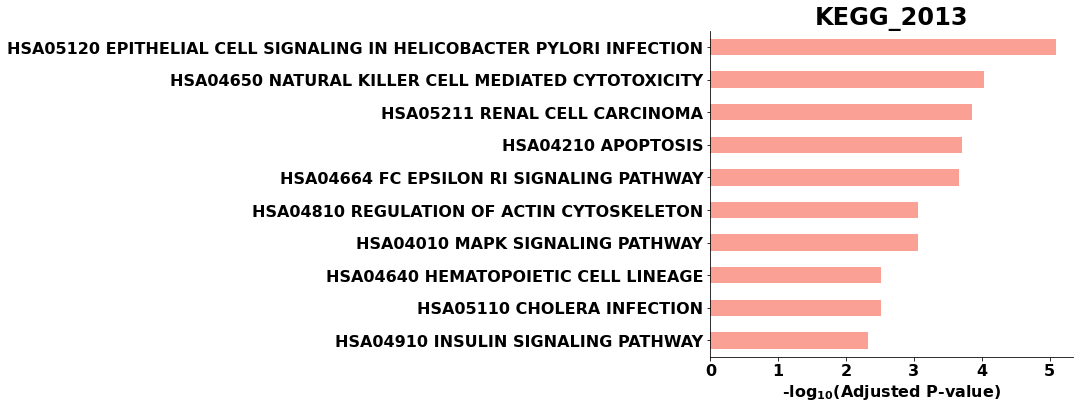

In [11]:
# simple plotting function
from gseapy.plot import barplot, dotplot

# to save your figure, make sure that ``ofname`` is not None
barplot(enr.res2d,title='KEGG_2013',)

<AxesSubplot:title={'center':'KEGG_2013'}, xlabel='-log$_{10}$(Adjusted P-value)'>

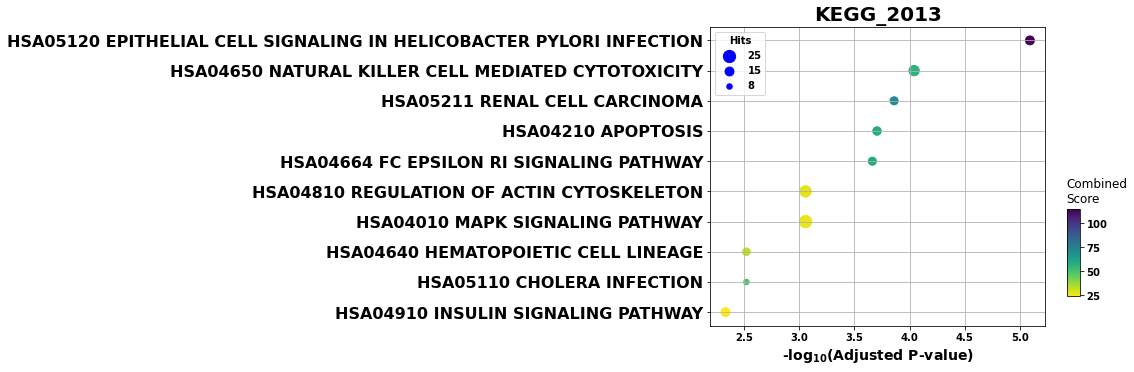

In [12]:
# to save your figure, make sure that ``ofname`` is not None
dotplot(enr.res2d, title='KEGG_2013',cmap='viridis_r')

### 2.2 Command line usage 

You may also want to use enrichr in command line  

the option **-v** will print out the progress of your job

In [13]:
# !gseapy enrichr -i ./data/gene_list.txt \
#                 --ds BP2017 \
#                 -g GO_Biological_Process_2017 \
#                 -v -o test/enrichr_BP

## 3. Prerank example

### 3.1 Assign prerank()  with a pd.DataFrame, pd.Series , or a txt file
Do not include header in your gene list !  
**GSEApy will skip any data after "#".**  
Only contains two columns, or one cloumn with gene_name indexed when assign a ``DataFrame`` to prerank

In [14]:
rnk = pd.read_csv("./tests/data/edb/gsea_data.gsea_data.rnk", header=None, sep="\t")
rnk.head()

,0,1
0,CTLA2B,2.502482
1,SCARA3,2.095578
2,LOC100044683,1.116398
3,CMBL,0.877640
4,CLIC6,0.822181


In [15]:
# run prerank
# enrichr libraries are supported by prerank module. Just provide the name
# use 4 process to acceralate the permutation speed

# note: multiprocessing may not work on windows
pre_res = gp.prerank(rnk=rnk, gene_sets='KEGG_2016', 
                     processes=4,
                     permutation_num=100, # reduce number to speed up testing
                     outdir='test/prerank_report_kegg', format='png', seed=6)

Leading edge genes save to the final output results

In [16]:
#access results through obj.res2d attribute or obj.results
pre_res.res2d.sort_index().head()

,es,nes,pval,fdr,geneset_size,matched_size,genes,ledge_genes
Term,,,,,,,,
Cytokine-cytokine receptor interaction Homo sapiens hsa04060,0.418234,1.526671,0.064935,0.591133,265,18,IL13RA1;CSF1;CCL2;TGFBR2;CD40;IL10RB;CXCL10;CX...,IL13RA1;CSF1;CCL2;TGFBR2;CD40;IL10RB;CXCL10
Focal adhesion Homo sapiens hsa04510,0.259225,0.859895,0.629032,0.993103,202,15,COL6A1;PARVA;FLNC;THBS4;LAMB3;PDGFRB;FLT4;ILK;...,COL6A1;PARVA;FLNC;THBS4;LAMB3;PDGFRB
HTLV-I infection Homo sapiens hsa05166,0.338286,1.344137,0.137931,0.643678,258,19,CRTC3;TGFBR2;CD40;PDGFRB;ADCY6;PPP3CC;ETS1;WNT...,CRTC3;TGFBR2;CD40;PDGFRB;ADCY6;PPP3CC;ETS1;WNT...
MAPK signaling pathway Homo sapiens hsa04010,0.179667,0.686976,0.847222,0.811166,255,18,CACNA1H;TGFBR2;FLNC;MAP3K5;PDGFRB;PPP3CC;NFATC...,CACNA1H;TGFBR2;FLNC;MAP3K5;PDGFRB;PPP3CC
Metabolic pathways Homo sapiens hsa01100,0.194868,0.902211,0.617647,1.000000,1239,36,CMBL;CDA;ST3GAL1;PLD2;CYP26A1;ENO2;GALNT4;PYGL...,CMBL;CDA;ST3GAL1;PLD2;CYP26A1;ENO2;GALNT4;PYGL


### 3.2 How to generate your GSEA plot inside python console  
Visualize it using ``gseaplot``  

Make sure that ``ofname`` is not None, if you want to save your figure to the disk

In [17]:
# extract geneset terms in res2d
terms = pre_res.res2d.index
terms

Index(['Pathways in cancer Homo sapiens hsa05200',
       'Cytokine-cytokine receptor interaction Homo sapiens hsa04060',
       'HTLV-I infection Homo sapiens hsa05166',
       'MAPK signaling pathway Homo sapiens hsa04010',
       'Rap1 signaling pathway Homo sapiens hsa04015',
       'PI3K-Akt signaling pathway Homo sapiens hsa04151',
       'Focal adhesion Homo sapiens hsa04510',
       'Ras signaling pathway Homo sapiens hsa04014',
       'Metabolic pathways Homo sapiens hsa01100'],
      dtype='object', name='Term')

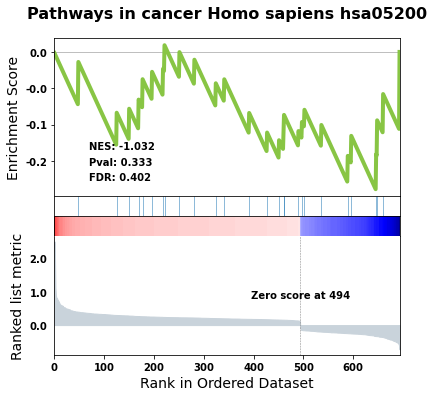

In [18]:
## easy way
from gseapy.plot import gseaplot

# to save your figure, make sure that ofname is not None
gseaplot(rank_metric=pre_res.ranking, term=terms[0], **pre_res.results[terms[0]])

# save figure
# gseaplot(rank_metric=pre_res.ranking, term=terms[0], ofname='your.plot.pdf', **pre_res.results[terms[0]])

### 3) Command line usage 

You may also want to use prerank in command line

In [19]:
# ! gseapy prerank -r temp.rnk -g temp.gmt -o prerank_report_temp

## 4. GSEA Example

### 4.1  Assign gsea() with a pandas DataFrame, .gct format file, or a text file

and cls with a list object or just .cls format file 

In [20]:
phenoA, phenoB, class_vector =  gp.parser.gsea_cls_parser("./tests/data/P53.cls")

In [21]:
#class_vector used to indicate group attributes for each sample
print(class_vector)

['MUT', 'MUT', 'MUT', 'MUT', 'MUT', 'MUT', 'MUT', 'MUT', 'MUT', 'MUT', 'MUT', 'MUT', 'MUT', 'MUT', 'MUT', 'MUT', 'MUT', 'MUT', 'MUT', 'MUT', 'MUT', 'MUT', 'MUT', 'MUT', 'MUT', 'MUT', 'MUT', 'MUT', 'MUT', 'MUT', 'MUT', 'MUT', 'MUT', 'WT', 'WT', 'WT', 'WT', 'WT', 'WT', 'WT', 'WT', 'WT', 'WT', 'WT', 'WT', 'WT', 'WT', 'WT', 'WT', 'WT']


In [22]:
gene_exp = pd.read_csv("./tests/data/P53.txt", sep="\t")
gene_exp.head()

,NAME,DESCRIPTION,786-0,BT-549,CCRF-CEM,COLO 205,EKVX,HCC-2998,HCT-15,HOP-62,...,MCF7,MOLT-4,NCI-H460,OVCAR-4,SF-539,SK-MEL-5,SR,UACC-257,UACC-62,UO-31
0,TACC2,na,46.05,82.17,16.87,98.60,141.02,114.32,134.34,44.95,...,68.14,32.21,105.89,64.99,53.52,85.47,18.69,32.16,45.70,48.13
1,C14orf132,na,108.34,59.04,25.61,33.11,42.53,9.12,9.36,310.96,...,159.32,10.71,13.59,53.78,57.57,86.80,17.30,102.66,62.16,73.44
2,AGER,na,42.20,25.75,76.01,40.41,32.17,48.28,58.27,42.40,...,51.50,61.48,44.44,45.68,54.17,62.53,83.18,56.57,50.40,36.75
3,32385_at,na,7.43,13.94,8.55,21.13,15.09,19.05,16.47,7.60,...,30.77,21.27,13.36,16.19,12.07,17.62,22.60,4.50,14.59,11.33
4,RBM17,na,11.40,3.00,3.16,2.34,4.43,1.56,6.04,6.16,...,1.62,2.77,4.42,8.91,12.28,3.04,10.13,8.32,8.23,3.91


In [23]:
print("positively correlated: ", phenoA)

positively correlated:  MUT


In [24]:
print("negtively correlated: ", phenoB)

negtively correlated:  WT


In [25]:
# run gsea
# enrichr libraries are supported by gsea module. Just provide the name

gs_res = gp.gsea(data=gene_exp, # or data='./P53_resampling_data.txt'
                 gene_sets='KEGG_2016', # enrichr library names
                 cls= './tests/data/P53.cls', # cls=class_vector
                 # set permutation_type to phenotype if samples >=15
                 permutation_type='phenotype', 
                 permutation_num=100, # reduce number to speed up test
                 outdir=None,  # do not write output to disk
                 no_plot=True, # Skip plotting
                 method='signal_to_noise',
                 processes=4, seed= 7,
                 format='png')

In [26]:
#access the dataframe results throught res2d attribute
gs_res.res2d.sort_index().head()

,es,nes,pval,fdr,geneset_size,matched_size,genes,ledge_genes
Term,,,,,,,,
ABC transporters Homo sapiens hsa02010,-0.328540,-1.174290,0.252174,0.594993,44,33,ABCD3;ABCD4;ABCA2;ABCB7;ABCD1;ABCA3;ABCC9;ABCB...,ABCG1;ABCC5;ABCB4;TAP2;CFTR;ABCC10;ABCB11;ABCC...
AGE-RAGE signaling pathway in diabetic complications Homo sapiens hsa04933,-0.261859,-1.046512,0.386555,0.739592,101,90,F3;PIK3CA;PLCE1;NRAS;RELA;RAC1;PLCB3;MAPK13;MA...,COL4A1;AKT3;VCAM1;PIK3R3;SMAD3;STAT1;THBD;SELE...
AMPK signaling pathway Homo sapiens hsa04152,0.198892,0.899468,0.714286,1.000000,124,89,PPP2R5B;PIK3CA;PPP2R5C;CREB3L1;PRKAA1;CREB3;PP...,PPP2R5B;PIK3CA;PPP2R5C;CREB3L1;PRKAA1;CREB3;PP...
Acute myeloid leukemia Homo sapiens hsa05221,0.196716,0.710123,0.900000,1.000000,57,50,MAP2K1;PIK3CA;NRAS;RELA;RPS6KB2;TCF7L2;JUP;RAF...,MAP2K1;PIK3CA;NRAS;RELA;RPS6KB2;TCF7L2;JUP;RAF...
Adherens junction Homo sapiens hsa04520,0.246805,0.984227,0.477941,1.000000,74,66,EP300;YES1;CTNND1;RAC1;WASF1;ERBB2;ACTN1;PTPRF...,EP300;YES1;CTNND1;RAC1;WASF1;ERBB2;ACTN1;PTPRF...


### 4.2 Show the gsea plots

The **gsea** module will generate heatmap for genes in each gene sets in the backgroud.  
But if you need to do it yourself, use the code below

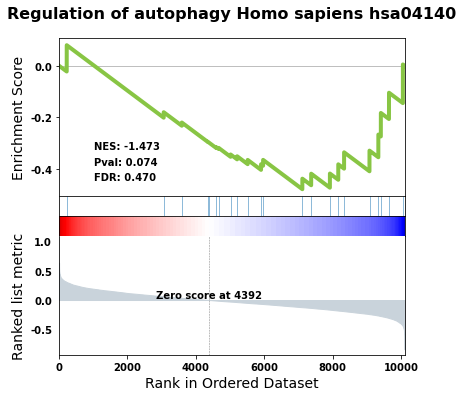

In [27]:
from gseapy.plot import gseaplot, heatmap
terms = gs_res.res2d.index
# Make sure that ``ofname`` is not None, if you want to save your figure to disk
gseaplot(gs_res.ranking, term=terms[0], **gs_res.results[terms[0]])

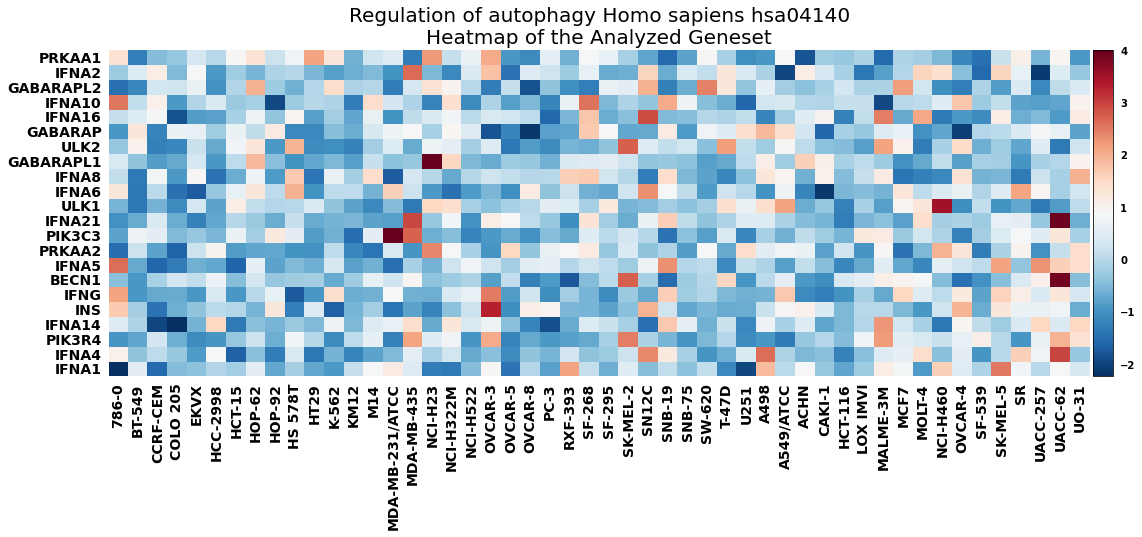

In [28]:
# plotting heatmap
genes = gs_res.res2d.genes[0].split(";")
# Make sure that ``ofname`` is not None, if you want to save your figure to disk
heatmap(df = gs_res.heatmat.loc[genes], z_score=0, title=terms[0], figsize=(18,6))

### 4.3 Command line usage 

You may also want to use gsea in command line

In [29]:
# !gseapy gsea -d ./data/P53_resampling_data.txt \
#              -g KEGG_2016 -c ./data/P53.cls \
#              -o test/gsea_reprot_2 \
#              -v --no-plot \
#              -t phenotype

## 5. Single Sample GSEA example

**Note: When you run ssGSEA, all genes names in your gene_sets file should be found in your expression table**

What's ssGSEA? Which one should I use? Prerank or ssGSEA

see FAQ [here](https://github.com/zqfang/GSEApy/wiki/FAQ)


### 5.1 Input format  
Assign ssgsea() with a txt file, gct file, pd.DataFrame, or pd.Seires(gene name as index)

In [30]:
# txt, gct file input
ss = gp.ssgsea(data="./tests/data/testSet_rand1200.gct",
               gene_sets="./tests/data/randomSets.gmt", 
               outdir='test/ssgsea_report', 
               sample_norm_method='rank', # choose 'custom' for your own rank list
               permutation_num=0, # skip permutation procedure, because you don't need it
               no_plot=True, # skip plotting, because you don't need these figures
               processes=4, format='png', seed=9)

In [31]:
ss.res2d.sort_index().head()

,AA488_A1.2,AA489_A2.2,AA490_A3,AA491_B1,AA492_B2,AA493_B3,AA494_C1.2,AA495_C2,AA496_C3,AA497_D1.2,AA498_D3.2,AA499_D2,AA500_x2,AA501_X3,AA502_X2.2,AA503_Y1,AA504_Y2,AA505_Y3
Term|NES,,,,,,,,,,,,,,,,,,
level10_RAND,0.409603,0.411949,0.402265,0.420727,0.423584,0.399554,0.417747,0.426646,0.415132,0.427609,0.428795,0.439772,0.439271,0.429857,0.421020,0.433811,0.436505,0.427802
level12_random,0.623556,0.637715,0.624758,0.636546,0.644973,0.628987,0.645339,0.633490,0.637938,0.647705,0.648328,0.638648,0.651963,0.650143,0.653187,0.660736,0.659942,0.649055
level2_rand,-0.271838,-0.281580,-0.271482,-0.278054,-0.279362,-0.260037,-0.294879,-0.290239,-0.286497,-0.294113,-0.285517,-0.286365,-0.334924,-0.331499,-0.337240,-0.336930,-0.334016,-0.339264
level4_rand,-0.061413,-0.090259,-0.063701,-0.094151,-0.094417,-0.053112,-0.096270,-0.081085,-0.080557,-0.092398,-0.091984,-0.078089,-0.119620,-0.119970,-0.129908,-0.143246,-0.138257,-0.126904
level6_rand,-0.061057,-0.054397,-0.061309,-0.052926,-0.055039,-0.047479,-0.059182,-0.070142,-0.061498,-0.055621,-0.058712,-0.062653,-0.020661,-0.017238,-0.011286,-0.018965,-0.017312,-0.008879


In [32]:
# or assign a dataframe, or Series to ssgsea()
ssdf = pd.read_csv("./tests/data/temp.txt", header=None, sep="\t")
ssdf.head()

,0,1
0,ATXN1,16.456753
1,UBQLN4,13.989493
2,CALM1,13.745533
3,DLG4,12.796588
4,MRE11A,12.787631


In [33]:
# dataframe with one column is also supported by ssGSEA or Prerank
# But you have to set gene_names as index
ssdf2 = ssdf.set_index(0)
ssdf2.head()

,1
0,
ATXN1,16.456753
UBQLN4,13.989493
CALM1,13.745533
DLG4,12.796588
MRE11A,12.787631


In [34]:
type(ssdf2)

pandas.core.frame.DataFrame

In [35]:
ssSeries = ssdf2.squeeze()
type(ssSeries)

pandas.core.series.Series

In [36]:
# reuse data
df = pd.read_csv("./tests/data/P53_resampling_data.txt", sep="\t")
df.head()

,NAME,786-0,BT-549,CCRF-CEM,COLO 205,EKVX,HCC-2998,HCT-15,HOP-62,HOP-92,...,MCF7,MOLT-4,NCI-H460,OVCAR-4,SF-539,SK-MEL-5,SR,UACC-257,UACC-62,UO-31
0,CTLA2B,111.19,86.22,121.85,75.19,208.62,130.59,124.72,324.09,242.71,...,163.76,59.50,134.12,152.09,197.46,137.79,81.53,123.37,81.41,180.78
1,SCARA3,460.30,558.34,183.55,37.29,158.00,43.61,80.83,300.08,1250.25,...,109.91,120.42,73.06,115.03,95.12,37.56,76.16,41.10,77.51,519.17
2,LOC100044683,97.25,118.94,81.17,119.51,119.88,107.73,165.57,203.97,135.43,...,222.84,124.98,114.75,141.66,170.19,147.70,157.48,152.18,98.89,118.06
3,CMBL,33.45,55.10,221.67,50.30,35.12,75.70,84.01,44.12,79.96,...,51.32,117.11,59.46,78.46,45.55,49.07,96.69,33.09,10.38,52.89
4,CLIC6,35.75,41.26,63.04,219.86,42.53,54.19,86.98,71.20,53.89,...,154.05,31.62,37.66,32.64,63.35,27.95,70.99,36.25,17.50,49.41


In [37]:
# Series, DataFrame Example
# supports dataframe and series
ssgs = []
for i, dat in enumerate([ssdf, ssdf2, ssSeries, df]):
    sstemp = gp.ssgsea(data=dat, 
                       gene_sets="./tests/data/genes.gmt", 
                       outdir='test/ssgsea_report_'+str(i),
                       scale=False, # set scale to False to get real original ES
                       permutation_num=0, # skip permutation procedure, because you don't need it
                       no_plot=True, # skip plotting, because you don't need these figures
                       processes=4, seed=10,
                       format='png')
    ssgs.append(sstemp)

2021-10-25 16:29:46,189 Warning: dropping duplicated gene names, only keep the first values


### 5.2 Access Enrichment Score (ES) and NES

results save to two attribute:

1. obj.resultsOnSamples: ES
2. obj.res2d: NES

In [38]:
# normalized es save to res2d attri
# one sample input
# NES
ssgs[0].res2d.sort_index().head()

,1
Term|NES,
BvA_UpIN_A,2.150128
BvA_UpIN_B,2.953868
DvA_UpIN_A,1.985465
DvA_UpIN_D,2.457505
YvX_UpIN_X,2.148830


**Note**: 
If you want to obtain the real original enrichment score,  
you have to set ``scale=False``

In [39]:
# ES
# convert dict to DataFrame
es = pd.DataFrame(ssgs[-1].resultsOnSamples)
es.sort_index().head()

,786-0,BT-549,CCRF-CEM,COLO 205,EKVX,HCC-2998,HCT-15,HOP-62,HOP-92,HS 578T,...,MCF7,MOLT-4,NCI-H460,OVCAR-4,SF-539,SK-MEL-5,SR,UACC-257,UACC-62,UO-31
DvA_UpIN_A,45.703475,6.724266,11.881146,20.639710,36.753558,3.530987,5.257504,33.003838,29.187991,41.457319,...,4.257227,17.789549,19.172561,37.144472,40.135942,18.082717,13.866768,44.562272,52.021549,51.185590
DvA_UpIN_D,82.960021,86.151980,88.176462,65.077923,80.856467,63.057273,53.557573,73.531016,85.803567,87.641491,...,72.490203,85.020685,76.225849,90.948093,97.684104,62.334470,68.204564,73.484066,68.094064,86.657296


In [40]:
# if set scale to True, then 
# Scaled ES equal to es/gene_numbers
ses = es/df.shape[0]
ses

,786-0,BT-549,CCRF-CEM,COLO 205,EKVX,HCC-2998,HCT-15,HOP-62,HOP-92,HS 578T,...,MCF7,MOLT-4,NCI-H460,OVCAR-4,SF-539,SK-MEL-5,SR,UACC-257,UACC-62,UO-31
DvA_UpIN_A,0.065855,0.009689,0.017120,0.029740,0.052959,0.005088,0.007576,0.047556,0.042058,0.059737,...,0.006134,0.025633,0.027626,0.053522,0.057833,0.026056,0.019981,0.064211,0.074959,0.073754
DvA_UpIN_D,0.119539,0.124138,0.127055,0.093772,0.116508,0.090861,0.077172,0.105952,0.123636,0.126285,...,0.104453,0.122508,0.109836,0.131049,0.140755,0.089819,0.098277,0.105885,0.098118,0.124866


In [41]:
# NES 
# scale or no have no affects on final nes value
nes = ssgs[-1].res2d
nes.sort_index().head()

,786-0,BT-549,CCRF-CEM,COLO 205,EKVX,HCC-2998,HCT-15,HOP-62,HOP-92,HS 578T,...,MCF7,MOLT-4,NCI-H460,OVCAR-4,SF-539,SK-MEL-5,SR,UACC-257,UACC-62,UO-31
Term|NES,,,,,,,,,,,,,,,,,,,,,
DvA_UpIN_A,0.402250,0.059182,0.104570,0.181656,0.323479,0.031077,0.046273,0.290477,0.256892,0.364879,...,0.037469,0.156571,0.168744,0.326920,0.353249,0.159152,0.122046,0.392206,0.457858,0.450500
DvA_UpIN_D,0.730157,0.758250,0.776068,0.572771,0.711643,0.554986,0.471377,0.647169,0.755184,0.771360,...,0.638009,0.748293,0.670887,0.800462,0.859748,0.548625,0.600289,0.646756,0.599317,0.762698


### 3) command line usage of single sample gsea

In [42]:
# set --no-scale to obtain the real original enrichment score
# !gseapy ssgsea -d ./data/testSet_rand1200.gct \
#                -g data/temp.gmt \
#                -o test/ssgsea_report2  \
#                -p 4 --no-plot --no-scale

## 6. Replot Example

### 6.1 locate your directory

notes: ``replot`` module need to find edb folder to work properly.
keep the file tree like this:
```
data
 |--- edb
 |    |--- C1OE.cls
 |    |--- gene_sets.gmt
 |    |--- gsea_data.gsea_data.rnk
 |    |--- results.edb

```

In [43]:
# run command inside python console
rep = gp.replot(indir="./tests/data", outdir="test/replot_test")

### 6.2 command line usage of replot

In [44]:
# !gseapy replot -i data -o test/replot_test